In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import umap
import umap.plot
import random
import pickle
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity

from scipy.io import loadmat
from revisitop.python.evaluate import compute_map, compute_ap

from torchvision.models import resnet50, ResNet50_Weights

/home/alcontreras/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/alcontreras/.local/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


## Carga de modelo Inception v3

In [4]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.fc = torch.nn.Identity()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Creacion datasets de torch

In [5]:
file_rox = "revisitop/data/datasets/roxford5k/gnd_roxford5k.pkl"
with open(file_rox, "rb") as f1:
    data_roxford5k = pickle.load(f1)

In [48]:
dataset_name ="roxford5k"

dataset_train = []
dataset_val = []

preprocess = weights.transforms() 

seed = 48

for i in tqdm(range(len(data_roxford5k['gnd'])), "Procesando"):
    easy_pos = data_roxford5k['gnd'][i]["easy"]
    hard_pos = data_roxford5k['gnd'][i]["hard"] 

    train_final = easy_pos+hard_pos

    anchor = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['qimlist'][i]}.jpg")
    crop_limits = data_roxford5k["gnd"][i]["bbx"]
    anchor = anchor.crop(crop_limits)

    for element in train_final:
        try:
            neg_random = random.choice(list(set(list(range(len(data_roxford5k['imlist'])))) - set(train_final)))
            pos_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][element]}.jpg")
            neg_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][neg_random]}.jpg")

            dataset_train.append([preprocess(anchor), preprocess(pos_img), preprocess(neg_img)])

            pos_img.close()
            neg_img.close()

        except:
            pass

Procesando: 100%|██████████| 70/70 [02:23<00:00,  2.05s/it]


In [160]:
weights.transforms()[1:]

TypeError: 'ImageClassification' object is not subscriptable

In [4]:
dataset_name ="roxford5k"

dataset_train = []
dataset_val = []

preprocess = weights.transforms() 

porcentaje = 1.0
seed = 48

for i in tqdm(range(len(data_roxford5k['gnd'])), "Procesando"):
    easy_pos = data_roxford5k['gnd'][i]["easy"]
    hard_pos = data_roxford5k['gnd'][i]["hard"] 

    num_elementos_easy = int(len(easy_pos) * porcentaje)
    num_elementos_hard = int(len(hard_pos) * porcentaje)
    
    random.seed(seed)
    train_easy = random.sample(easy_pos, num_elementos_easy)
    val_easy = list(set(easy_pos) - set(train_easy))
    
    random.seed(seed)
    train_hard= random.sample(hard_pos, num_elementos_hard)
    val_hard = list(set(hard_pos) - set(train_hard))

    train_final = train_easy+train_hard
    val_final = val_easy+val_hard

    anchor = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['qimlist'][i]}.jpg")
    crop_limits = data_roxford5k["gnd"][i]["bbx"]
    anchor = anchor.crop(crop_limits)

    for element in train_final:
        try:
            neg_random = random.choice(list(set(list(range(len(data_roxford5k['imlist'])))) - set(train_final)))
            pos_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][element]}.jpg")
            neg_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][neg_random]}.jpg")

            dataset_train.append([transform(anchor), transform(pos_img), transform(neg_img)])

            pos_img.close()
            neg_img.close()

        except:
            pass


    for element in val_final:
        try:
            neg_random = random.choice(list(set(list(range(len(data_roxford5k['imlist'])))) - set(val_final)))
            pos_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][element]}.jpg")
            neg_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][neg_random]}.jpg")

            dataset_val.append([transform(anchor), transform(pos_img), transform(neg_img)])

            pos_img.close()
            neg_img.close()

        except:
            pass

Procesando: 100%|██████████| 70/70 [02:09<00:00,  1.85s/it]


In [49]:
train_dataset = torch.stack([torch.stack(sublista) for sublista in dataset_train]).to(device)
#val_dataset = torch.stack([torch.stack(sublista) for sublista in dataset_val]).to(device)

In [163]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6000, shuffle=True)


In [164]:
batch = next(iter(train_loader))

anchor_img = batch[:,0,:,:]
positive_img = batch[:,1,:,:]
negative_img = batch[:,2,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


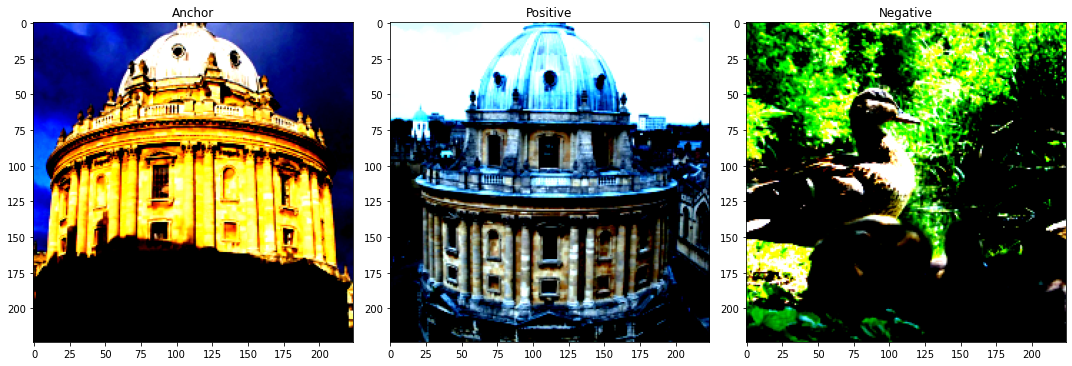

In [172]:
idx = 4914
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(anchor_img[idx].permute(1, 2, 0).cpu())
axs[0].set_title('Anchor')

axs[1].imshow(positive_img[idx].permute(1, 2, 0).cpu())
axs[1].set_title('Positive')

axs[2].imshow(negative_img[idx].permute(1, 2, 0).cpu())
axs[2].set_title('Negative')

fig.tight_layout()
plt.show()

## Funcion de entrenamiento

In [173]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [177]:
import time

def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    batch_size,
    lr,
    optimizador,
    criterion,
    early_stopping_tolerance=10,
    save_best_model = True,
):

    #early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance, save_best= save_best_model)

    #Curvas de aprendizaje
    curves = {
            "train_loss": [],
            "val_loss": [],
        }

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Optimizador
    optimizer = optimizador

    # Early stopping
    #n_epochs_with_no_improvement = 0
    #stop = False

    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0

        model.train()

        for i, batch in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i+1}/{len(train_loader)}", end="")

            optimizer.zero_grad()

            anchor_img = batch[:,0,:,:]
            positive_img = batch[:,1,:,:]
            negative_img = batch[:,2,:,:]

            # Predicción
            anchor_out = model(anchor_img)
            pos_out = model(positive_img)
            neg_out = model(negative_img)

            # Loss
            loss = criterion(anchor_out, pos_out, neg_out)

            # Actualización de parámetros
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

        train_loss = cumulative_train_loss / len(train_loader)

        # Evaluación del modelo
        #model.eval()
        #with torch.no_grad():
        #    for i, (batch) in enumerate(val_loader):

         #       anchor_img = batch[:,0,:,:]
          #      positive_img = batch[:,1,:,:]
          #      negative_img = batch[:,2,:,:]

                # Predicción
          #      anchor_out = model(anchor_img)
          #      pos_out = model(positive_img)
          #      neg_out = model(negative_img)

                # Loss
          #      val_loss = criterion(anchor_out, pos_out, neg_out).item()/len(val_loader)


        print("")
        print(f" - Train loss: {train_loss:.5f}")#, Val loss: {val_loss:.5f}")

        #if early_stopping(val_loss,model.state_dict(),epoch):
        #    print("Early stopping.")
        #    break

        curves["train_loss"].append(train_loss)
        #curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    return curves

In [178]:
def plot_curves(curves):

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["train_loss"])) + 1

    #ax.plot(epochs, curves['val_loss'], label='Val')
    ax.plot(epochs, curves['train_loss'], label='Train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss evolution during training')
    ax.legend()

    plt.tight_layout()

    plt.show()

## Entrenamiento

In [179]:
EPOCH = 60
BATCH_SIZE = 16
LR = 1e-7
criterion = TripletLoss()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

curves= train_model(
        model= model,
        train_dataset=train_dataset,
        val_dataset=train_dataset,
        max_epochs=EPOCH,
        batch_size=BATCH_SIZE,
        lr=LR,
        optimizador= optimizer,
        criterion = criterion,
        early_stopping_tolerance=10,
        save_best_model=True,
    )

Epoch 1/60 - Batch 346/346
 - Train loss: 4.66992
Epoch 2/60 - Batch 346/346
 - Train loss: 4.71499
Epoch 3/60 - Batch 346/346
 - Train loss: 4.19862
Epoch 4/60 - Batch 346/346
 - Train loss: 3.78533
Epoch 5/60 - Batch 346/346
 - Train loss: 3.67333
Epoch 6/60 - Batch 346/346
 - Train loss: 3.07907
Epoch 7/60 - Batch 346/346
 - Train loss: 2.96742
Epoch 8/60 - Batch 346/346
 - Train loss: 2.81001
Epoch 9/60 - Batch 346/346
 - Train loss: 2.68746
Epoch 10/60 - Batch 346/346
 - Train loss: 2.27256
Epoch 11/60 - Batch 346/346
 - Train loss: 2.36911
Epoch 12/60 - Batch 346/346
 - Train loss: 1.93054
Epoch 13/60 - Batch 346/346
 - Train loss: 1.79304
Epoch 14/60 - Batch 346/346
 - Train loss: 1.70792
Epoch 15/60 - Batch 346/346
 - Train loss: 1.53264
Epoch 16/60 - Batch 346/346
 - Train loss: 1.36479
Epoch 17/60 - Batch 346/346
 - Train loss: 1.33602
Epoch 18/60 - Batch 346/346
 - Train loss: 1.24786
Epoch 19/60 - Batch 346/346
 - Train loss: 1.25239
Epoch 20/60 - Batch 346/346
 - Train los

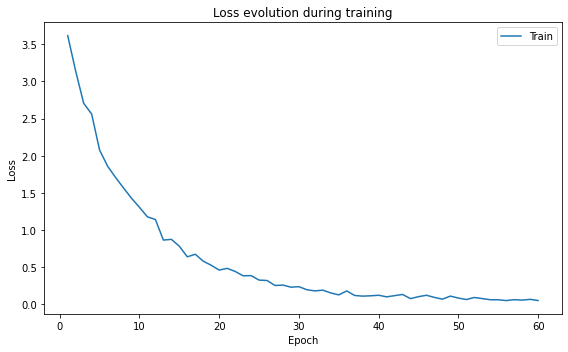

In [11]:
plot_curves(curves)

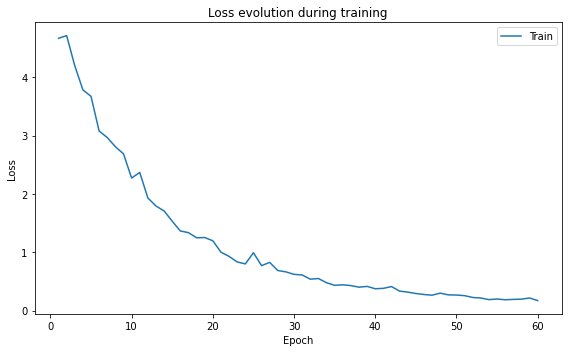

In [180]:
plot_curves(curves)

## Predicciones

In [181]:
class CustomDataset(Dataset):
    def __init__(self, root_dir,data,query,transform=None):
        self.root_dir = root_dir
        self.query= query
        self.transform = transform
        self.data =data
        
        self.file_list = data['qimlist'] if query else data['imlist']
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f'{self.file_list[idx]}.jpg')
        image = Image.open(img_name)
        
        if self.query:
            crop_limits = self.data["gnd"][idx]["bbx"]
            image = image.crop(crop_limits)

        if self.transform != None:
            image = self.transform(image)

        return image

In [182]:
def feature_extractor(dataset_name, model, preprocess, device):
    
    root_dir = f"revisitop/data/datasets/{dataset_name}/jpg"
    file = f"revisitop/data/datasets/{dataset_name}/gnd_{dataset_name}.pkl"
    with open(file, "rb") as f:
        data = pickle.load(f)

    db_dataset = CustomDataset(root_dir=root_dir, data=data,query=False, transform=preprocess)
    query_dataset = CustomDataset(root_dir=root_dir, data=data,query=True, transform=preprocess)
        
    db_features = []
    for imagen in tqdm(db_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            db_features.append(features.squeeze(0).cpu().numpy())

    querys_features = []
    for imagen in tqdm(query_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            querys_features.append(features.squeeze(0).cpu().numpy())
            
    db_features = np.vstack(db_features)
    querys_features = np.vstack(querys_features)  
    
    return db_features, querys_features

In [184]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [185]:
db_features_oxford, querys_features_oxford = feature_extractor("roxford5k",model,preprocess,device=device)

Extrayendo Caracteristicas: 100%|██████████| 70/70 [00:01<00:00, 37.59it/s]


In [190]:
db_features_paris, querys_features_paris = feature_extractor("rparis6k",model.to(device),preprocess,device=device)

Extrayendo Caracteristicas: 100%|██████████| 70/70 [00:01<00:00, 39.16it/s]


## Evaluacion

In [186]:
def evaluate(db,querys, data):
    
    cosine_sim = cosine_similarity(db, querys)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]
    
    gnd = data['gnd']

    # evaluate ranks
    ks = [1,2,100]

    # search for easy
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['hard']])
        gnd_t.append(g)
    mapE, apsE, mprE, prsE = compute_map(ranks, gnd_t, ks)

    # search for easy & hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk']])
        gnd_t.append(g)
    mapM, apsM, mprM, prsM = compute_map(ranks, gnd_t, ks)

    # search for hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['easy']])
        gnd_t.append(g)
    mapH, apsH, mprH, prsH = compute_map(ranks, gnd_t, ks)

    print('>> {}: mAP E: {}, M: {}, H: {}'.format("roxford5k", np.around(mapE*100, decimals=2), np.around(mapM*100, decimals=2), np.around(mapH*100, decimals=2)))

In [13]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k)

>> roxford5k: mAP E: 24.81, M: 19.04, H: 5.15


In [187]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k)

>> roxford5k: mAP E: 14.04, M: 10.94, H: 2.36


In [192]:
file_par = "revisitop/data/datasets/rparis6k/gnd_rparis6k.pkl"
with open(file_par, "rb") as f2:
    data_rparis6k = pickle.load(f2)

In [193]:
evaluate(db_features_paris,querys_features_paris, data_rparis6k)

>> roxford5k: mAP E: 45.24, M: 36.58, H: 16.96


## UMAP

In [188]:
labels = np.zeros(len(data_roxford5k['imlist']))

for i in tqdm(range(len(data_roxford5k['gnd'])), "Procesando"):
    easy_pos = data_roxford5k['gnd'][i]["easy"]
    hard_pos = data_roxford5k['gnd'][i]["hard"] 

    true_pos = easy_pos+hard_pos
    all_pos = list(range(len(db_features_oxford)))
    mascara = list(map(lambda x: x in set(true_pos), all_pos))

    labels[mascara] = i

Procesando: 100%|██████████| 70/70 [00:00<00:00, 90.27it/s] 


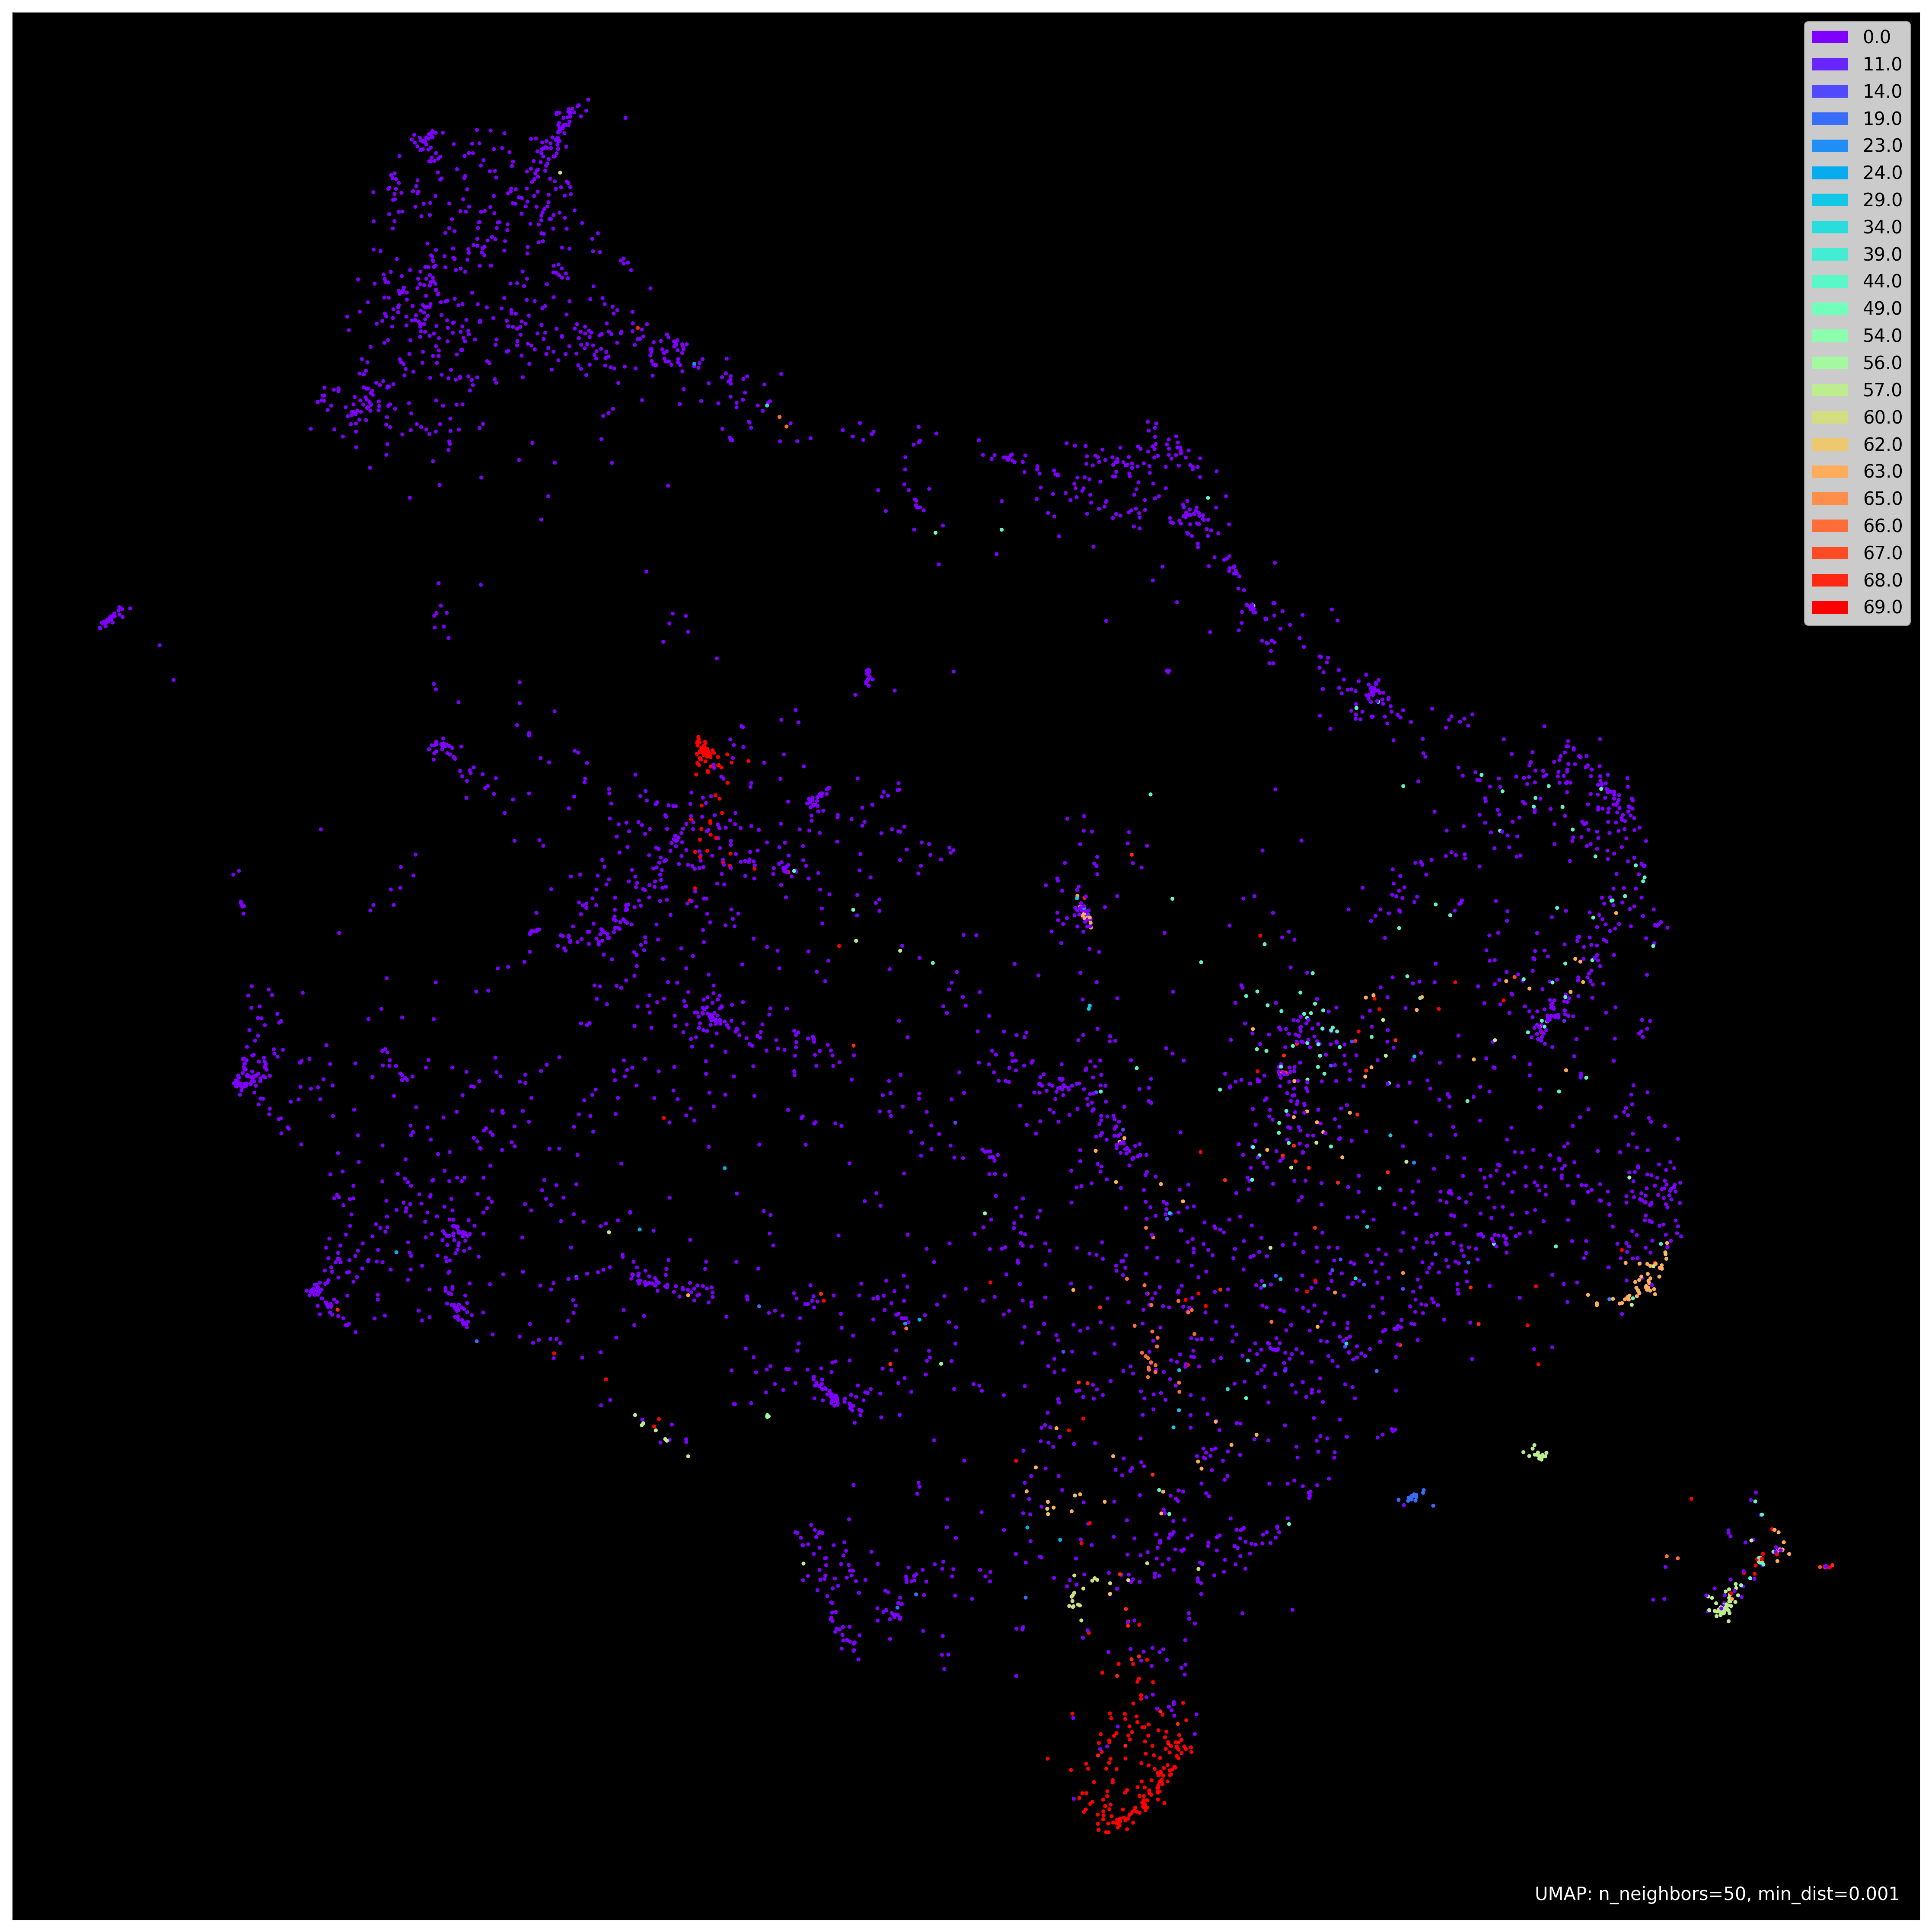

In [46]:
mapper = umap.UMAP(n_neighbors=50, min_dist=0.001, random_state=48, n_jobs=1).fit(db_features_oxford)

fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
umap.plot.points(mapper, labels=labels, theme='fire',ax=ax)
plt.tight_layout()
plt.show()

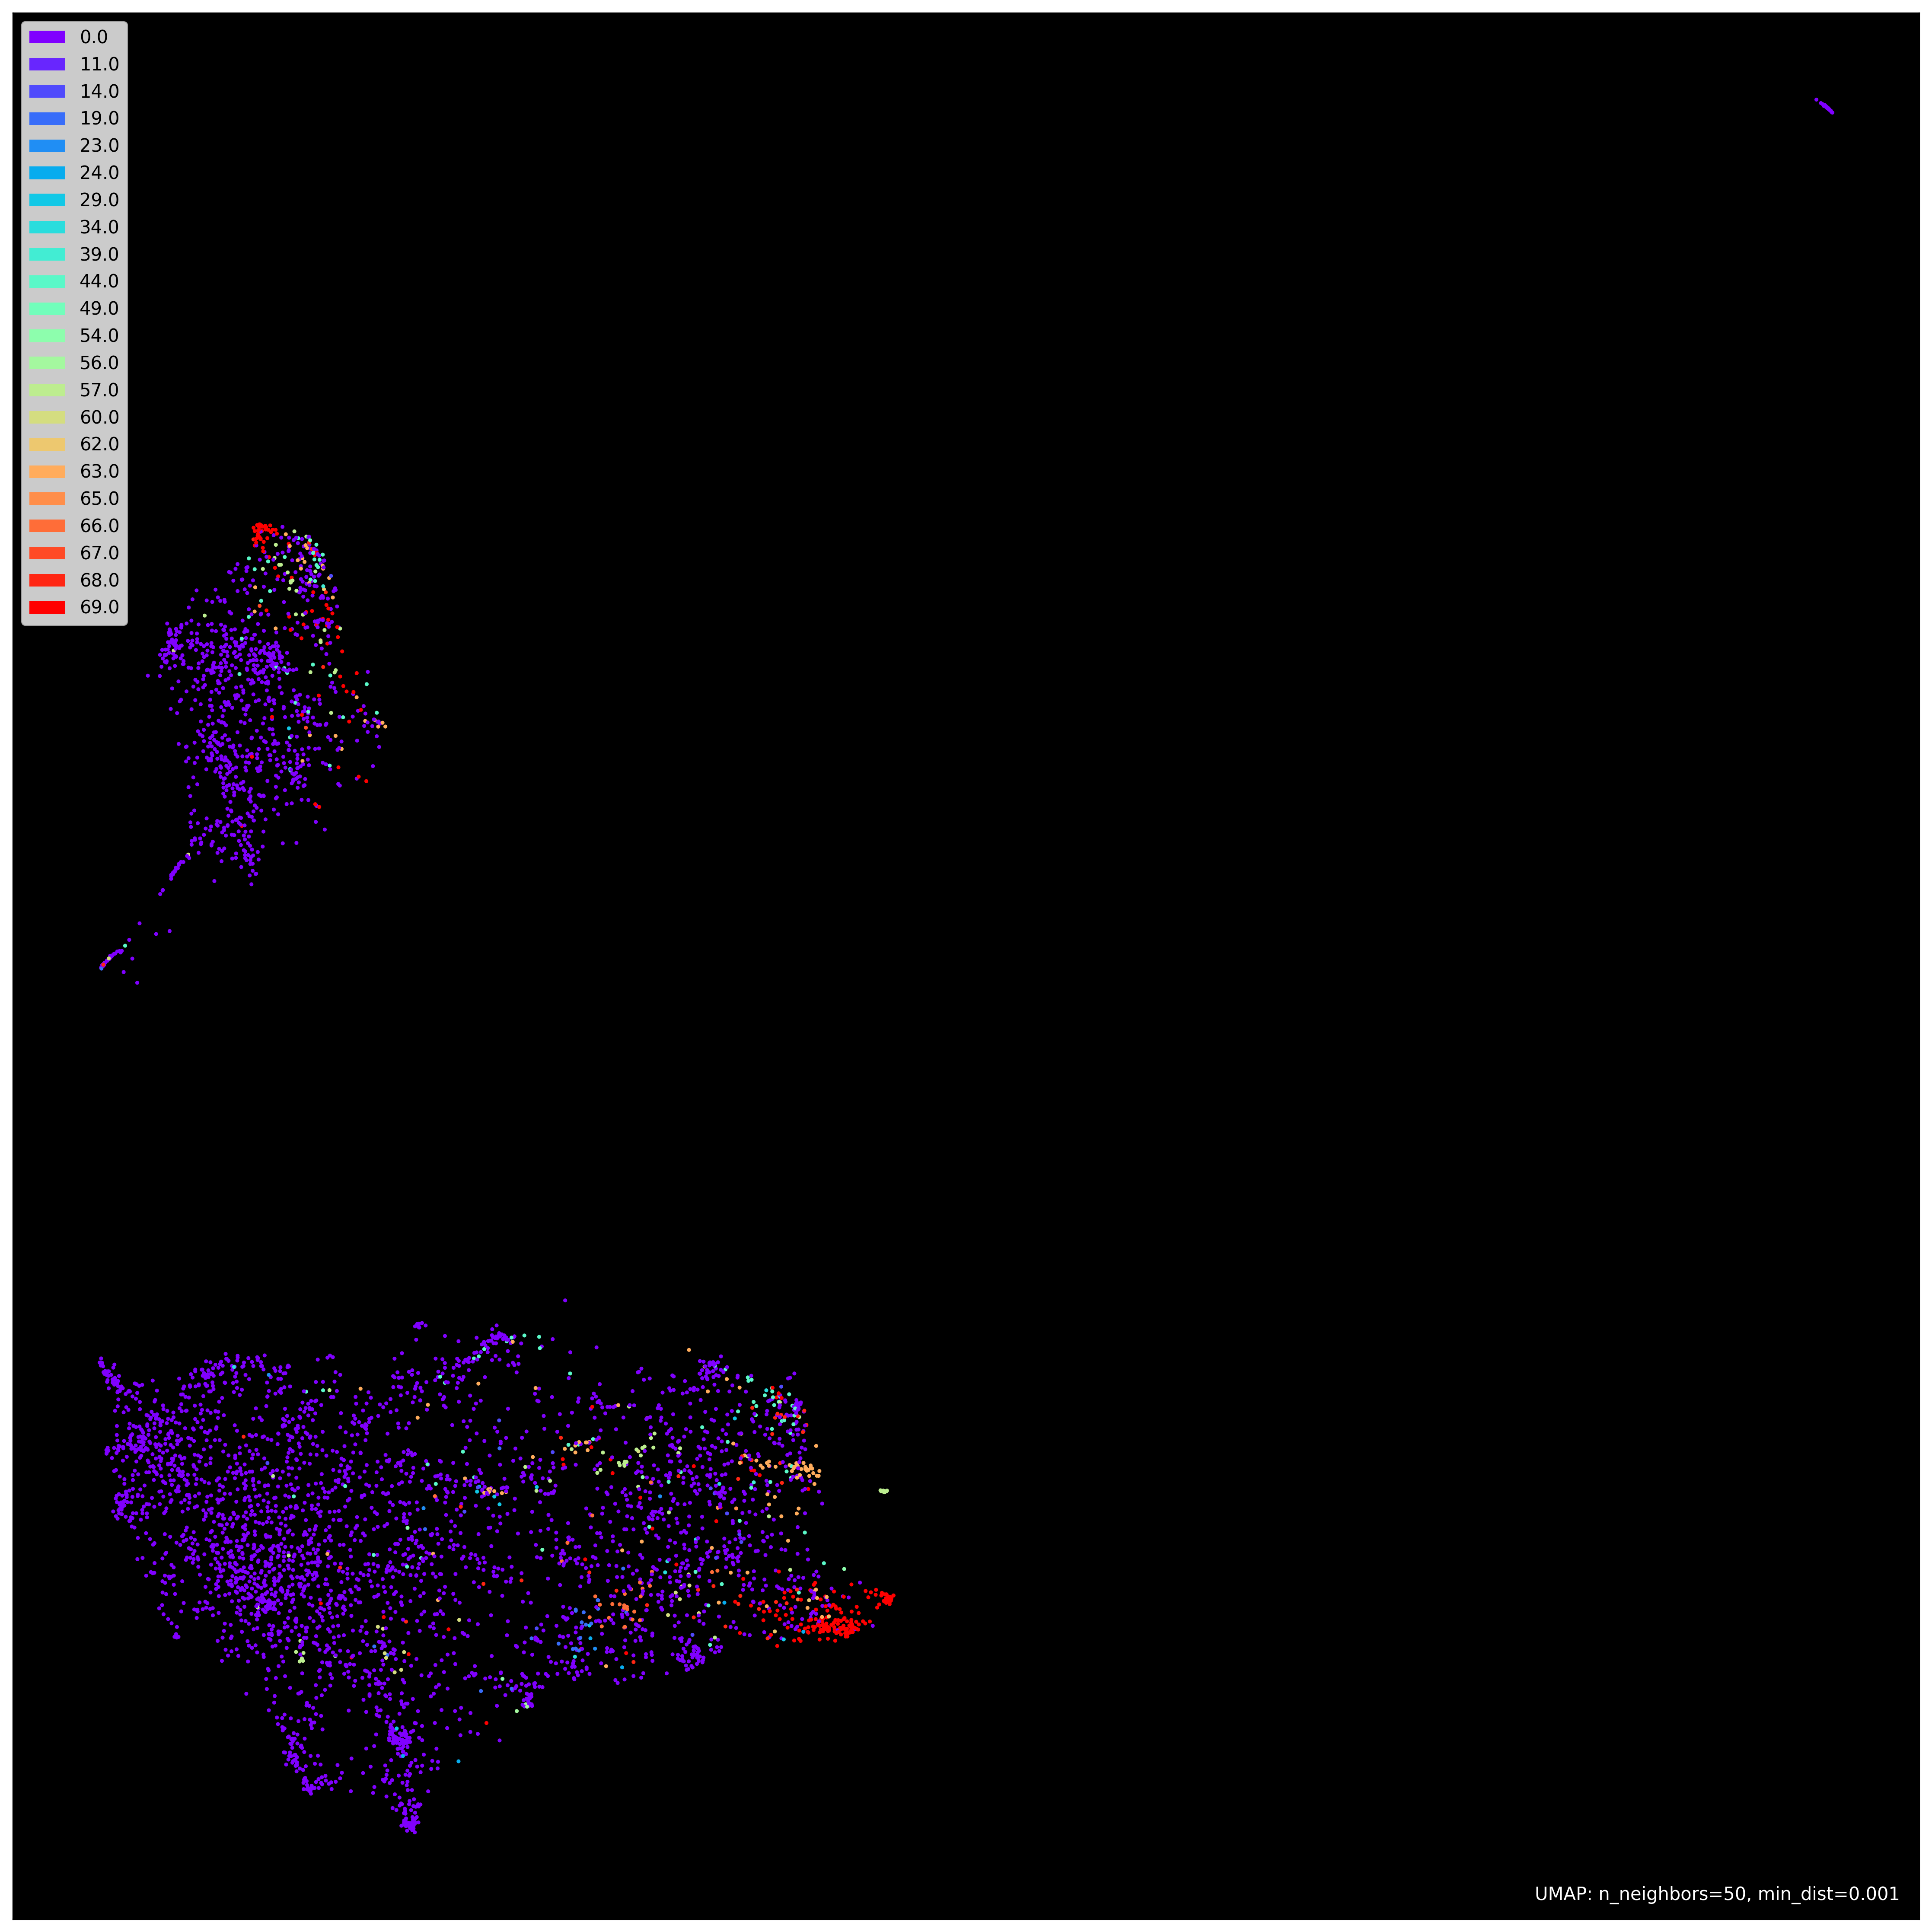

In [189]:
mapper = umap.UMAP(n_neighbors=50, min_dist=0.001, random_state=48, n_jobs=1).fit(db_features_oxford)

fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
umap.plot.points(mapper, labels=labels, theme='fire',ax=ax)
plt.tight_layout()
plt.show()